In [1]:
from keras import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from keras import backend as K
from scipy.io import loadmat

## Load Data

In [2]:
img_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Image/',
    labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    batch_size=None,
    interpolation="bilinear",
)


mask_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Segmentation_Mask/',
    label_mode="int",
        labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    color_mode="grayscale",
    batch_size=None,
    interpolation="bilinear",
)

def cast_to_int(image):
    return tf.cast(image, tf.int32)

img_train_data1 = img_data.map(cast_to_int)
mask_train_data1 = mask_data.map(cast_to_int)

#zip image and mask
train_data = tf.data.Dataset.zip((img_train_data1, mask_train_data1))

#train test split
train_size = int(0.6 * 1000)
test_size = int(0.2 * 1000)
val_size = int(0.2 * 1000)

train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.take(train_size)
test_data = train_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)

BUFFER_SIZE = 27460*0.6
BATCH_SIZE = 32
train_dataset = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_data.batch(BATCH_SIZE)


Found 27460 files belonging to 1 classes.
Found 27460 files belonging to 1 classes.


In [5]:
train_data

<ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.int32, name=None))>

### test image show

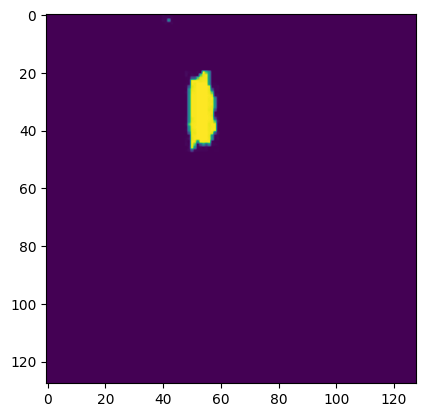

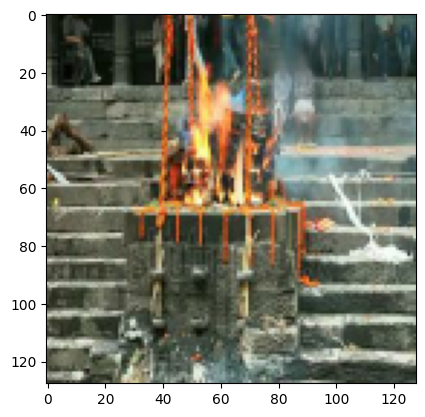

In [6]:
image, mask = next(iter(train_data))
import matplotlib.pyplot as plt

plt.imshow(mask)
plt.show()

plt.imshow(image)
plt.show()

In [8]:
train_data

<TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.int32, name=None))>

## Functions

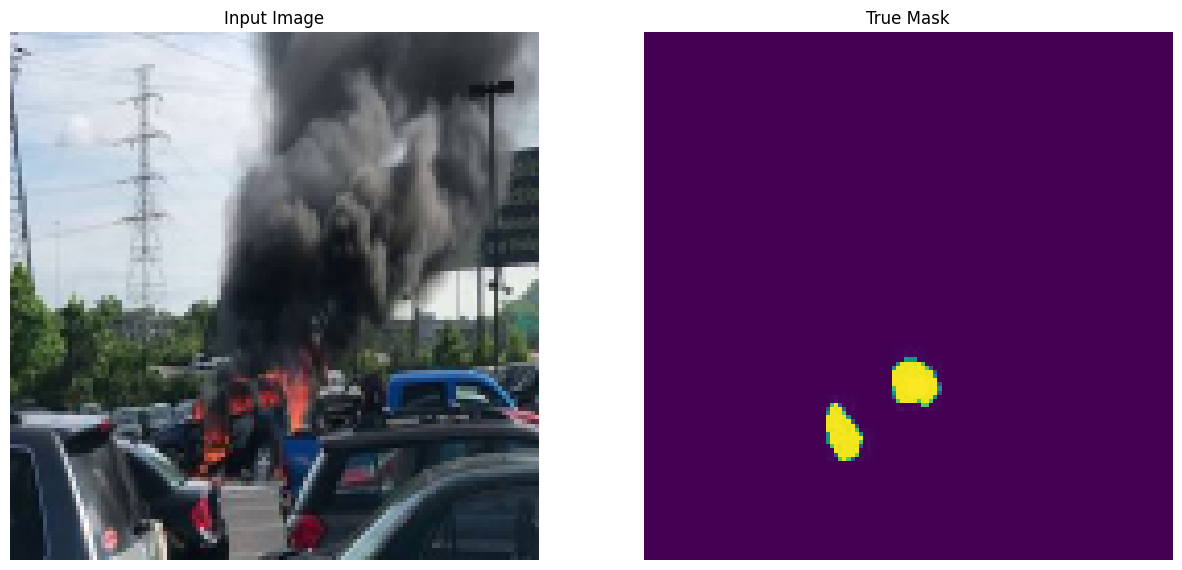

In [9]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# train.take(1) method takes the first element f
for image, mask in train_data.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [10]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## Model 1

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [12]:
# function to create the mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [14]:
#clear session
tf.keras.backend.clear_session()

## Model 3

In [15]:
def fcn(vgg, classes = 1, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [16]:
vgg = VGG16(include_top=False, weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=(128, 128, 3))


In [17]:
#clear session
K.clear_session()

In [18]:
model = fcn(vgg, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [19]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

c:\Users\ASUS\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]


In [21]:
train_length = 27460*0.6
STEPS_PER_EPOCH = train_length // BATCH_SIZE
model.fit(train_dataset, validation_data=val_dataset, batch_size=16, epochs=5,steps_per_epoch=STEPS_PER_EPOCH, callbacks=callbacks)

Epoch 1/5
514/514 [==============================] - 221s 309ms/step - loss: nan - accuracy: 0.8616
Epoch 2/5
514/514 [==============================] - 153s 298ms/step - loss: nan - accuracy: 0.9725
Epoch 3/5
514/514 [==============================] - 160s 311ms/step - loss: nan - accuracy: 0.9725
Epoch 4/5
 96/514 [====>.........................] - ETA: 2:04 - loss: nan - accuracy: 0.9725

KeyboardInterrupt: 

## Model 4

In [22]:
K.clear_session()